In [1]:
library(proxy)
library(mlr3)
library(rpart.plot)
library(mlr3learners)
library(data.table)
library(mlr3verse)


Attaching package: 'proxy'


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Loading required package: rpart



## Solution 2: Classifying spam

### a)

The spam data has a binary classification problem, where the aim is to classify an e-mail as spam or non-spam, saved in variable "type".

In [2]:
#| label: 2-a
tsk("spam")

<TaskClassif:spam> (4601 x 58): HP Spam Detection
* Target: type
* Properties: twoclass
* Features (57):
  - dbl (57): address, addresses, all, business, capitalAve,
    capitalLong, capitalTotal, charDollar, charExclamation, charHash,
    charRoundbracket, charSemicolon, charSquarebracket, conference,
    credit, cs, data, direct, edu, email, font, free, george, hp, hpl,
    internet, lab, labs, mail, make, meeting, money, num000, num1999,
    num3d, num415, num650, num85, num857, order, original, our, over,
    parts, people, pm, project, re, receive, remove, report, table,
    technology, telnet, will, you, your

### b)

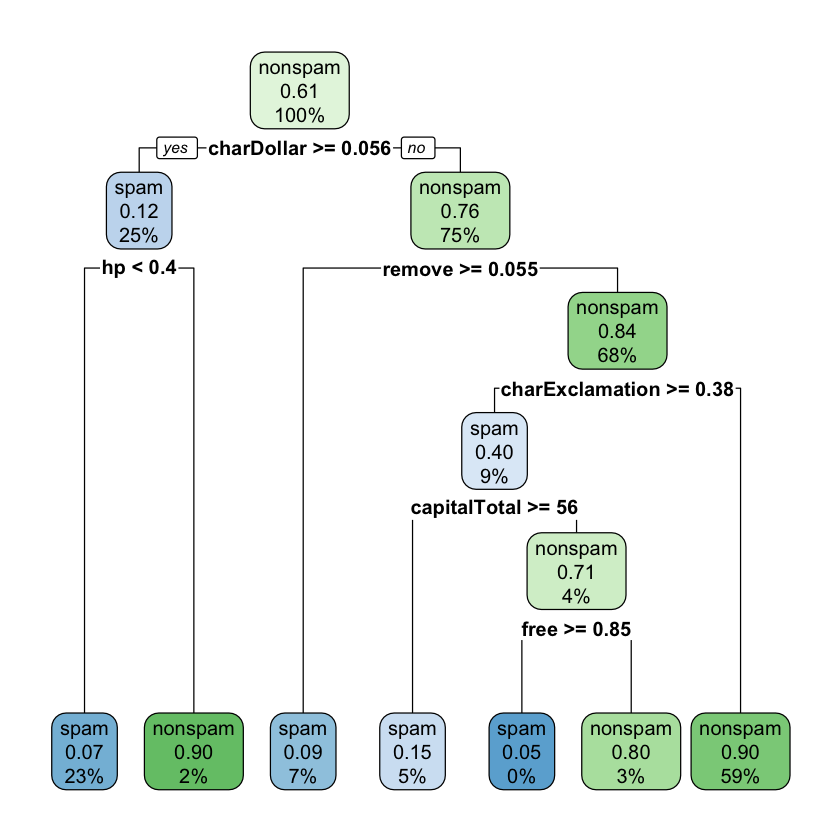

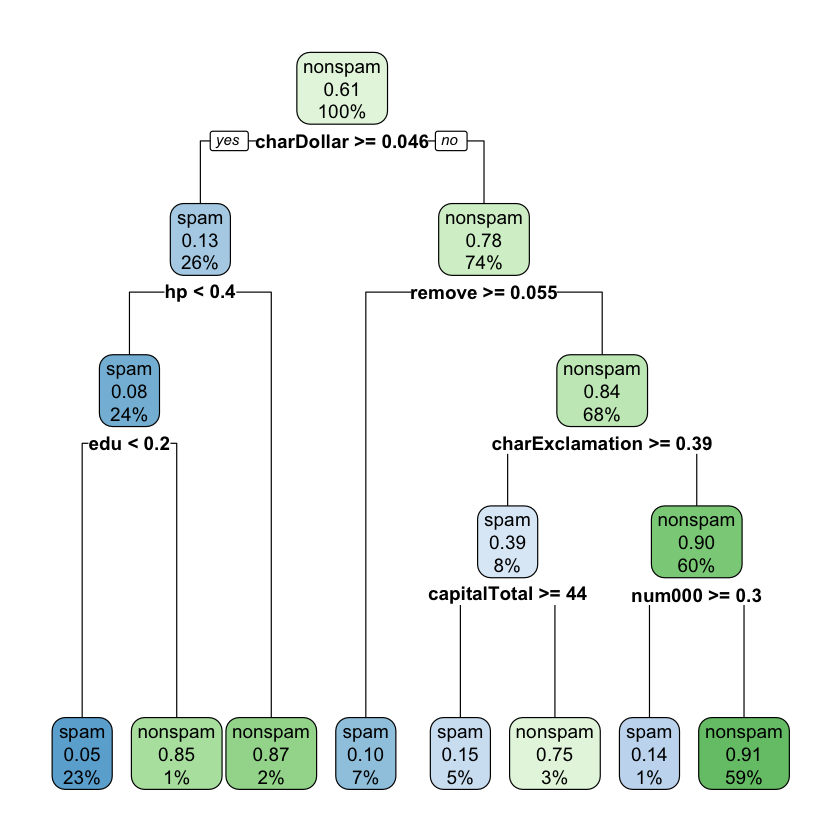

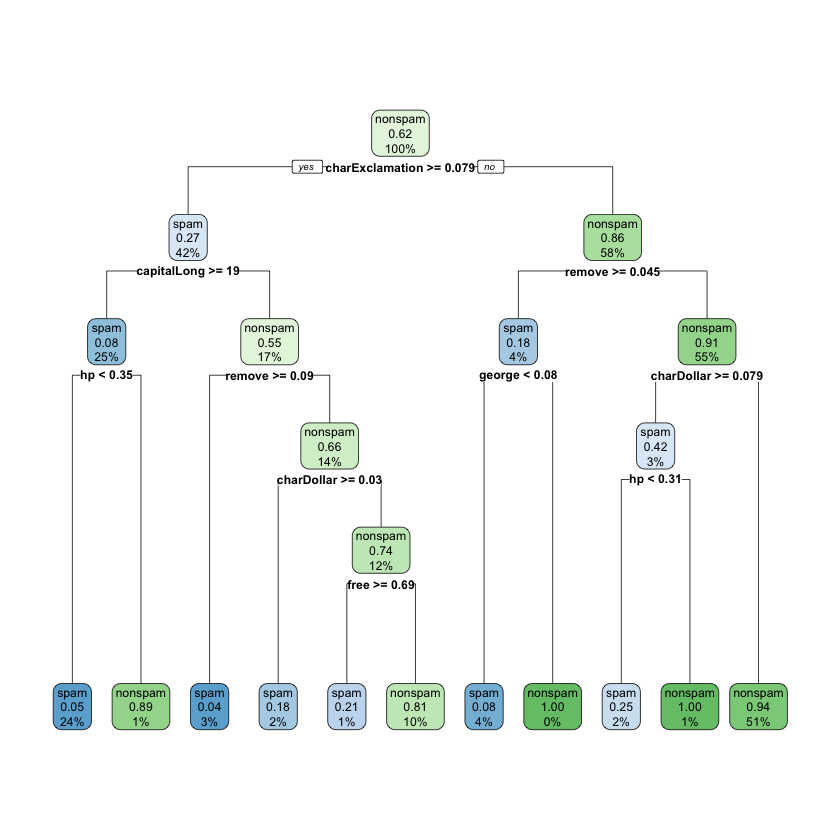

In [3]:
#| label: 2-b
task_spam <- tsk("spam")

learner <- lrn("classif.rpart")
learner$train(task_spam)

set.seed(123)
rpart.plot(learner$model, roundint = FALSE)

set.seed(456)
subset_1 <- sample.int(task_spam$nrow, size = 0.6 * task_spam$nrow)
set.seed(789)
subset_2 <- sample.int(task_spam$nrow, size = 0.6 * task_spam$nrow)

for (i in list(subset_1, subset_2)) {
  learner$train(task_spam, row_ids = i)
  rpart.plot(learner$model, roundint = FALSE)
}

Observation: trees trained on different samples differ considerably in their structure, regarding split variables as well as thresholds (recall, though, that the split candidates are a further source of randomness).

### c)

### i)

This is actually quite easy when we recall that the exponential 
    function at an arbitrary input $x$ can be characterized via
    $$e^x = \lim_{n \to \infty} \left( 1 + \tfrac{x}{n} \right)^n, $$
    which already resembles the limit expression we are looking 
    for. 
    Setting $x$ to -1 yields:
    $$\lim_{n \to \infty} \left( 1 - \tfrac{1}{n} \right)^n = e^{-1} = 
    \tfrac{1}{e}.$$

### ii)

In [4]:
#| label: 2-c
learner <- lrn("classif.ranger", "oob.error" = TRUE)
learner$train(tsk("spam"))
learner$model$prediction.error

[1] 0.04694632

### d)

Variable importance in general measures the contributions of features to a model.
One way of computing the variable importance of the $j$-th variable is based on 
permuting it for the OOB observations and calculating the mean increase in OOB 
error this permutation entails.

In order to determine the with the biggest influence on prediction 
quality, we can choose the $k$ variables with the highest importance score,
e.g., for $k = 5$:

In [5]:
#| label: 2-d
library(mlr3filters)

learner <- lrn("classif.ranger", importance = "permutation", "oob.error" = TRUE)  
filter <- flt("importance", learner = learner)
filter$calculate(tsk("spam"))
head(as.data.table(filter), 5)

feature,score
<chr>,<dbl>
capitalLong,0.04533696
hp,0.04197165
charExclamation,0.03969858
remove,0.03817609
capitalAve,0.03455630


## Solution 3: Proximities

### a)

The following table prints for each observation (rows) their terminal nodes as assigned by trees 1-3. For example,
consider observation 1 in tree 1 (first cell): the observation has phenols > 1.94, putting it in node 2 (rightChild
of node 0), from there in node 6 (because it has alcohol > 13.04).

In [6]:
set.seed(123L)
task <- tsk("wine")
task$select(
  c("alcalinity", "alcohol", "flavanoids", "hue", "malic", "phenols")
)
n_trees <- 3L
learner <- lrn("classif.ranger", num.trees = n_trees, max.depth = 2L)
learner$train(task)

x_sample <- task$data()[sample(seq_len(task$nrow), 3L)]
x_sample[, type := NULL][, id := .I]
setcolorder(x_sample, "id")

In [7]:
#| label: 3-a-1
end_nodes <- predict(
    learner$model, x_sample, type = "terminalNodes"
  )$predictions
  end_nodes <- data.table(end_nodes)
  setnames(end_nodes, sprintf("tree_%i", seq_along(end_nodes)))
end_nodes

tree_1,tree_2,tree_3
<dbl>,<dbl>,<dbl>
6,6,6
5,4,5
6,6,6


### b)

For the proximities, we consider each pair of observations and compute the relative frequency of trees assigning
them to the same terminal node.
- Observations 1 and 2: only tree 1 assigns them to the same node, so the proximity is $\tfrac{1}{3}$.
- Observations 1 and 3: all trees assign them to the same node, so the proximity is 1.
- Observations 2 and 3: only tree 1 assigns them to the same node, so the proximity is $\tfrac{1}{3}$.

### c)

We can put this information into a similarity matrix (as such matrices become large quite quickly for more
data, it is common to store only the lower diagonal – the rest is non-informative/redundant):

In [8]:
#| label: 3-c-1
compute_prox <- function(i, j) sum(i == j) / length(i)
round(proxy::dist(end_nodes, method = compute_prox), 2L)

  1 2
2 0  
3 1 0